In [2]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

In [3]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.layers import Flatten, Dense, Dropout
from keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM

In [4]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from keras.models import load_model
from scipy import stats
import mediapipe_test as MP

In [5]:
data_path = os.path.join('Data') 
action_list = np.array(['merhaba', 'nasilsin', 'hayir','gunaydin','tesekkur','evet','bilmiyorum',
                    'gorusuruz','iyigunler','ozurdilerim'])
video_count = 40  
frame_count = 40  

In [6]:
actionIndex  = {}
for num, label in enumerate(action_list):
    actionIndex[label] = num

In [7]:
input_data, input_labels = [], []
for action in action_list:
    for data_num in range(video_count):
        frame_list = []
        for frame_num in range(frame_count):
            frame_path = os.path.join(data_path, action, str(data_num), "{}.npy".format(frame_num))
            frame_data = np.load(frame_path)
            frame_list.append(frame_data)
        input_data.append(frame_list)
        input_labels.append(actionIndex[action])

In [8]:
X = np.array(input_data)

In [9]:
y = to_categorical(input_labels).astype(int)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim

In [10]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, activation='tanh', input_shape=(40, 258)))
model.add(Dropout(0.2))

model.add(LSTM(units=256, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))

model.add(LSTM(units=128, return_sequences=False, activation='tanh'))
model.add(Dropout(0.2))

model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

model.add(Dense(units=10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 40, 128)           198144    
                                                                 
 dropout (Dropout)           (None, 40, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 40, 256)           394240    
                                                                 
 dropout_1 (Dropout)         (None, 40, 256)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8

In [15]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [16]:
history=model.fit(X_train, y_train, epochs=60,batch_size=32,validation_data=(X_test, y_test))

Epoch 1/60
10/10 [==============================] - 5s 219ms/step - loss: 3.0544 - accuracy: 0.1594 - val_loss: 2.7950 - val_accuracy: 0.1750
Epoch 2/60
10/10 [==============================] - 1s 133ms/step - loss: 2.6544 - accuracy: 0.2562 - val_loss: 2.5326 - val_accuracy: 0.1375
Epoch 3/60
10/10 [==============================] - 1s 132ms/step - loss: 2.4281 - accuracy: 0.2750 - val_loss: 2.3500 - val_accuracy: 0.3625
Epoch 4/60
10/10 [==============================] - 1s 134ms/step - loss: 2.2549 - accuracy: 0.3344 - val_loss: 2.1696 - val_accuracy: 0.3750
Epoch 5/60
10/10 [==============================] - 1s 134ms/step - loss: 2.0556 - accuracy: 0.4250 - val_loss: 1.8971 - val_accuracy: 0.5375
Epoch 6/60
10/10 [==============================] - 1s 132ms/step - loss: 1.9072 - accuracy: 0.4969 - val_loss: 1.8145 - val_accuracy: 0.5750
Epoch 7/60
10/10 [==============================] - 1s 132ms/step - loss: 1.6694 - accuracy: 0.5813 - val_loss: 1.7620 - val_accuracy: 0.5375
Epoch 

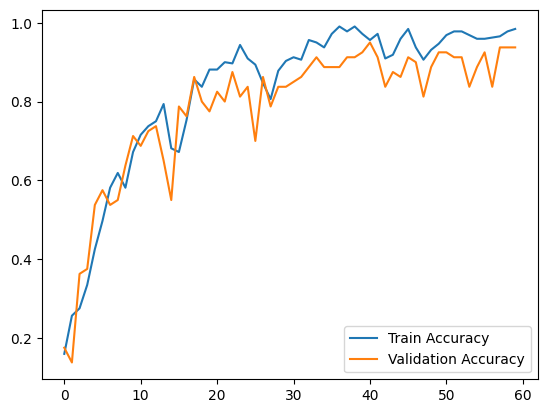

In [17]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

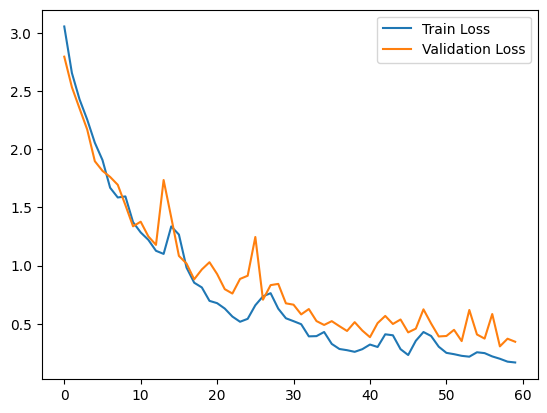

In [18]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.34639889001846313
Test accuracy: 0.9375


# Test 

In [11]:
model = load_model('lstmodel6.h5')

In [12]:
res=model.predict(X_test)

3/3 [==============================] - 1s 54ms/step


In [13]:
color = (27,165,91)
def get_result(res, action_list, input_frame, color):
    output_frame = input_frame.copy()
    active_action_index = None
    active_action_prob = 0.0

    for num, prob in enumerate(res):
        if 0.8 <= prob <= 1.0:
            if prob > active_action_prob:
                active_action_index = num
                active_action_prob = prob

    if active_action_index is not None:
        active_action = action_list[active_action_index]
        text = f"{active_action}: {active_action_prob:.3f}"
        cv2.rectangle(output_frame, (0, 30), (int(active_action_prob * 100), 60), color, -1)
        cv2.putText(output_frame, text, (0, 55), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2, cv2.LINE_AA)

    return output_frame

In [14]:
def get_keypoint_data(results):
    if results.pose_landmarks:
        pose = np.array([[pose_landmark.x, pose_landmark.y, pose_landmark.z, pose_landmark.visibility] for pose_landmark in results.pose_landmarks.landmark]).flatten()
    else:
        pose = np.zeros(33*4)

    if results.left_hand_landmarks:
        left_hand = np.array([[hand_landmark.x, hand_landmark.y, hand_landmark.z] for hand_landmark in results.left_hand_landmarks.landmark]).flatten()
    else:
        left_hand = np.zeros(21*3)

    if results.right_hand_landmarks:
        right_hand = np.array([[hand_landmark.x, hand_landmark.y, hand_landmark.z] for hand_landmark in results.right_hand_landmarks.landmark]).flatten()
    else:
        right_hand = np.zeros(21*3)

    return np.concatenate([pose, left_hand, right_hand])

In [15]:
keypoint_sequence = []
action_sentence = []
threshold = 0.8

cap = cv2.VideoCapture(0)

with MP.mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        ret, frame = cap.read()
        
        image, results = MP.process_image(frame, holistic)

        MP.draw_customized_landmarks(image, results)
        
        keypointData = get_keypoint_data(results)
        keypoint_sequence.append(keypointData)
        keypoint_sequence = keypoint_sequence[-40:]
        
        if len(keypoint_sequence) == 40:            
            res  = model.predict(np.expand_dims(keypoint_sequence, axis=0))[0]            
            if res[np.argmax(res)] > threshold: 
                if len(action_sentence) > 0: 
                    if action_list[np.argmax(res)] != action_sentence[-1]:
                        action_sentence.append(action_list[np.argmax(res)])
                else:
                    action_sentence.append(action_list[np.argmax(res)])

            if len(action_sentence) >10: 
                action_sentence = action_sentence[-10:]

            image = get_result(res, action_list, image, color)
        
        cv2.imshow('Camera', image)

        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 24ms/step


In [30]:
from sklearn.metrics import confusion_matrix, accuracy_score,precision_score,recall_score,classification_report

In [19]:
y_predict = model.predict(X_test)

3/3 [==============================] - 0s 49ms/step


In [20]:
y_true = np.argmax(y_test, axis=1).tolist()
y_predict = np.argmax(y_predict, axis=1).tolist() 

In [35]:
cm=confusion_matrix(y_true,y_predict)

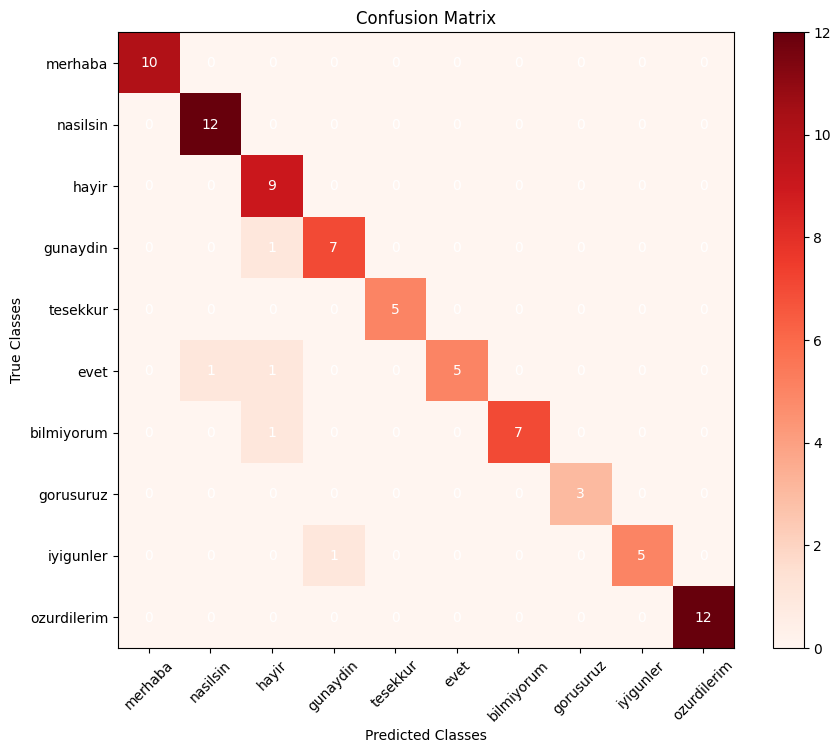

In [36]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.xticks(np.arange(len(action_list)), action_list, rotation=45)
plt.yticks(np.arange(len(action_list)), action_list)
plt.show()

In [40]:
report = classification_report(y_true, y_predict, target_names=action_list)

In [42]:
print(report)

              precision    recall  f1-score   support

     merhaba       1.00      1.00      1.00        10
    nasilsin       0.92      1.00      0.96        12
       hayir       0.75      1.00      0.86         9
    gunaydin       0.88      0.88      0.88         8
    tesekkur       1.00      1.00      1.00         5
        evet       1.00      0.71      0.83         7
  bilmiyorum       1.00      0.88      0.93         8
   gorusuruz       1.00      1.00      1.00         3
   iyigunler       1.00      0.83      0.91         6
 ozurdilerim       1.00      1.00      1.00        12

    accuracy                           0.94        80
   macro avg       0.95      0.93      0.94        80
weighted avg       0.95      0.94      0.94        80

